In [10]:
seed = 1999

import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

# stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm
from scipy.stats import shapiro

# processing
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler, MinMaxScaler # the data already seems scaled?
from sklearn.compose import ColumnTransformer

# eval
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import fbeta_score

# models
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import time

import warnings
warnings.filterwarnings('ignore')


from classifier.eda_utils import *

## useful Examples and Notebooks
https://www.kaggle.com/code/bryamblasrimac/prediction-creditcardfraud-eda-multiplemodels
- working through this notebook on credit card data. Make adjustments, keeping what is good and critisizing what is bad. 


In [11]:
# grab data

data = pd.read_csv("~/ds_ml/datasets/creditcard_2023.csv")
data.columns = [i.lower() for i in data.columns]
data.shape, data.duplicated().sum()

((568630, 31), 0)

In [12]:
data.head()

,id,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,-0.987020,0.293438,-0.941386,0.549020,1.804879,0.215598,0.512307,0.333644,0.124270,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,0.140107,1.564246,0.574074,0.627719,0.706121,0.789188,0.403810,0.201799,-0.340687,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,-0.272985,0.659201,0.805173,0.616874,3.069025,-0.577514,0.886526,0.239442,-2.366079,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,-0.752581,0.737483,0.592994,0.559535,-0.697664,-0.030669,0.242629,2.178616,-1.345060,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,-1.203171,1.029577,1.439310,0.241454,0.153008,0.224538,0.366466,0.291782,0.445317,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [13]:
data.isnull().sum().sort_values(ascending=False).head()

id        0
v16       0
amount    0
v28       0
v27       0
dtype: int64

In [14]:
data.drop('id', axis=1, inplace=True)
data.describe() # classes are already balanced 

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
count,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,5.686300e+05,568630.000000,568630.0
mean,-5.638058e-17,-1.319545e-16,-3.518788e-17,-2.879008e-17,7.997245e-18,-3.958636e-17,-3.198898e-17,2.109273e-17,3.998623e-17,1.991314e-16,-1.183592e-16,-5.758017e-17,-5.698037e-18,-4.078595e-17,2.649087e-17,-1.719408e-17,-3.398829e-17,-5.837989e-17,2.479146e-17,-1.579456e-17,4.758361e-17,3.948640e-18,6.194741e-18,-2.799036e-18,-3.178905e-17,-7.497417e-18,-3.598760e-17,2.609101e-17,12041.957635,0.5
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,6919.644449,0.5
min,-3.495584e+00,-4.996657e+01,-3.183760e+00,-4.951222e+00,-9.952786e+00,-2.111111e+01,-4.351839e+00,-1.075634e+01,-3.751919e+00,-3.163276e+00,-5.954723e+00,-2.020399e+00,-5.955227e+00,-2.107417e+00,-3.861813e+00,-2.214513e+00,-2.484938e+00,-2.421949e+00,-7.804988e+00,-7.814784e+01,-1.938252e+01,-7.734798e+00,-3.029545e+01,-4.067968e+00,-1.361263e+01,-8.226969e+00,-1.049863e+01,-3.903524e+01,50.010000,0.0
25%,-5.652859e-01,-4.866777e-01,-6.492987e-01,-6.560203e-01,-2.934955e-01,-4.458712e-01,-2.835329e-01,-1.922572e-01,-5.687446e-01,-5.901008e-01,-7.014495e-01,-8.311331e-01,-6.966667e-01,-8.732057e-01,-6.212485e-01,-7.162655e-01,-6.194913e-01,-5.560458e-01,-5.653082e-01,-3.502399e-01,-1.664408e-01,-4.904892e-01,-2.376289e-01,-6.515801e-01,-5.541485e-01,-6.318948e-01,-3.049607e-01,-2.318783e-01,6054.892500,0.0
50%,-9.363846e-02,-1.358939e-01,3.528579e-04,-7.376152e-02,8.108788e-02,7.871758e-02,2.333659e-01,-1.145242e-01,9.252647e-02,2.626145e-01,-4.104986e-02,1.620521e-01,1.760812e-02,2.305011e-01,-3.925566e-02,1.340262e-01,2.716407e-01,8.729382e-02,-2.597869e-02,-1.233776e-01,-3.743065e-02,-2.732881e-02,-5.968903e-02,1.590123e-02,-8.193162e-03,-1.189208e-02,-1.729111e-01,-1.392973e-02,12030.150000,0.5
75%,8.326582e-01,3.435552e-01,6.285380e-01,7.070047e-01,4.397368e-01,4.977881e-01,5.259548e-01,4.729905e-02,5.592621e-01,5.924603e-01,7.477730e-01,7.446723e-01,6.856048e-01,7.518216e-01,6.654065e-01,6.556061e-01,5.182242e-01,5.443887e-01,5.601164e-01,2.482164e-01,1.479787e-01,4.638817e-01,1.557153e-01,7.007374e-01,5.500147e-01,6.728879e-01,3.340230e-01,4.095903e-01,18036.330000,1.0
max,2.229046e+00,4.361865e+00,1.412583e+01,3.201536e+00,4.271689e+01,2.616840e+01,2.178730e+02,5.958040e+00,2.027006e+01,3.172271e+01,2.513573e+00,1.791356e+01,7.187486e+00,1.916954e+01,1.453220e+01,4.665291e+01,6.994124e+00,6.783716e+00,3.831672e+00,2.987281e+01,8.087080e+00,1.263251e+01,3.170763e+01,1.296564e+01,1.462151e+01,5.623285e+00,1.132311e+02,7.725594e+01,24039.930000,1.0


In [15]:
# collecting float types for plotting
cols_to_plot = data.select_dtypes(include = ["float"]).columns.to_list()

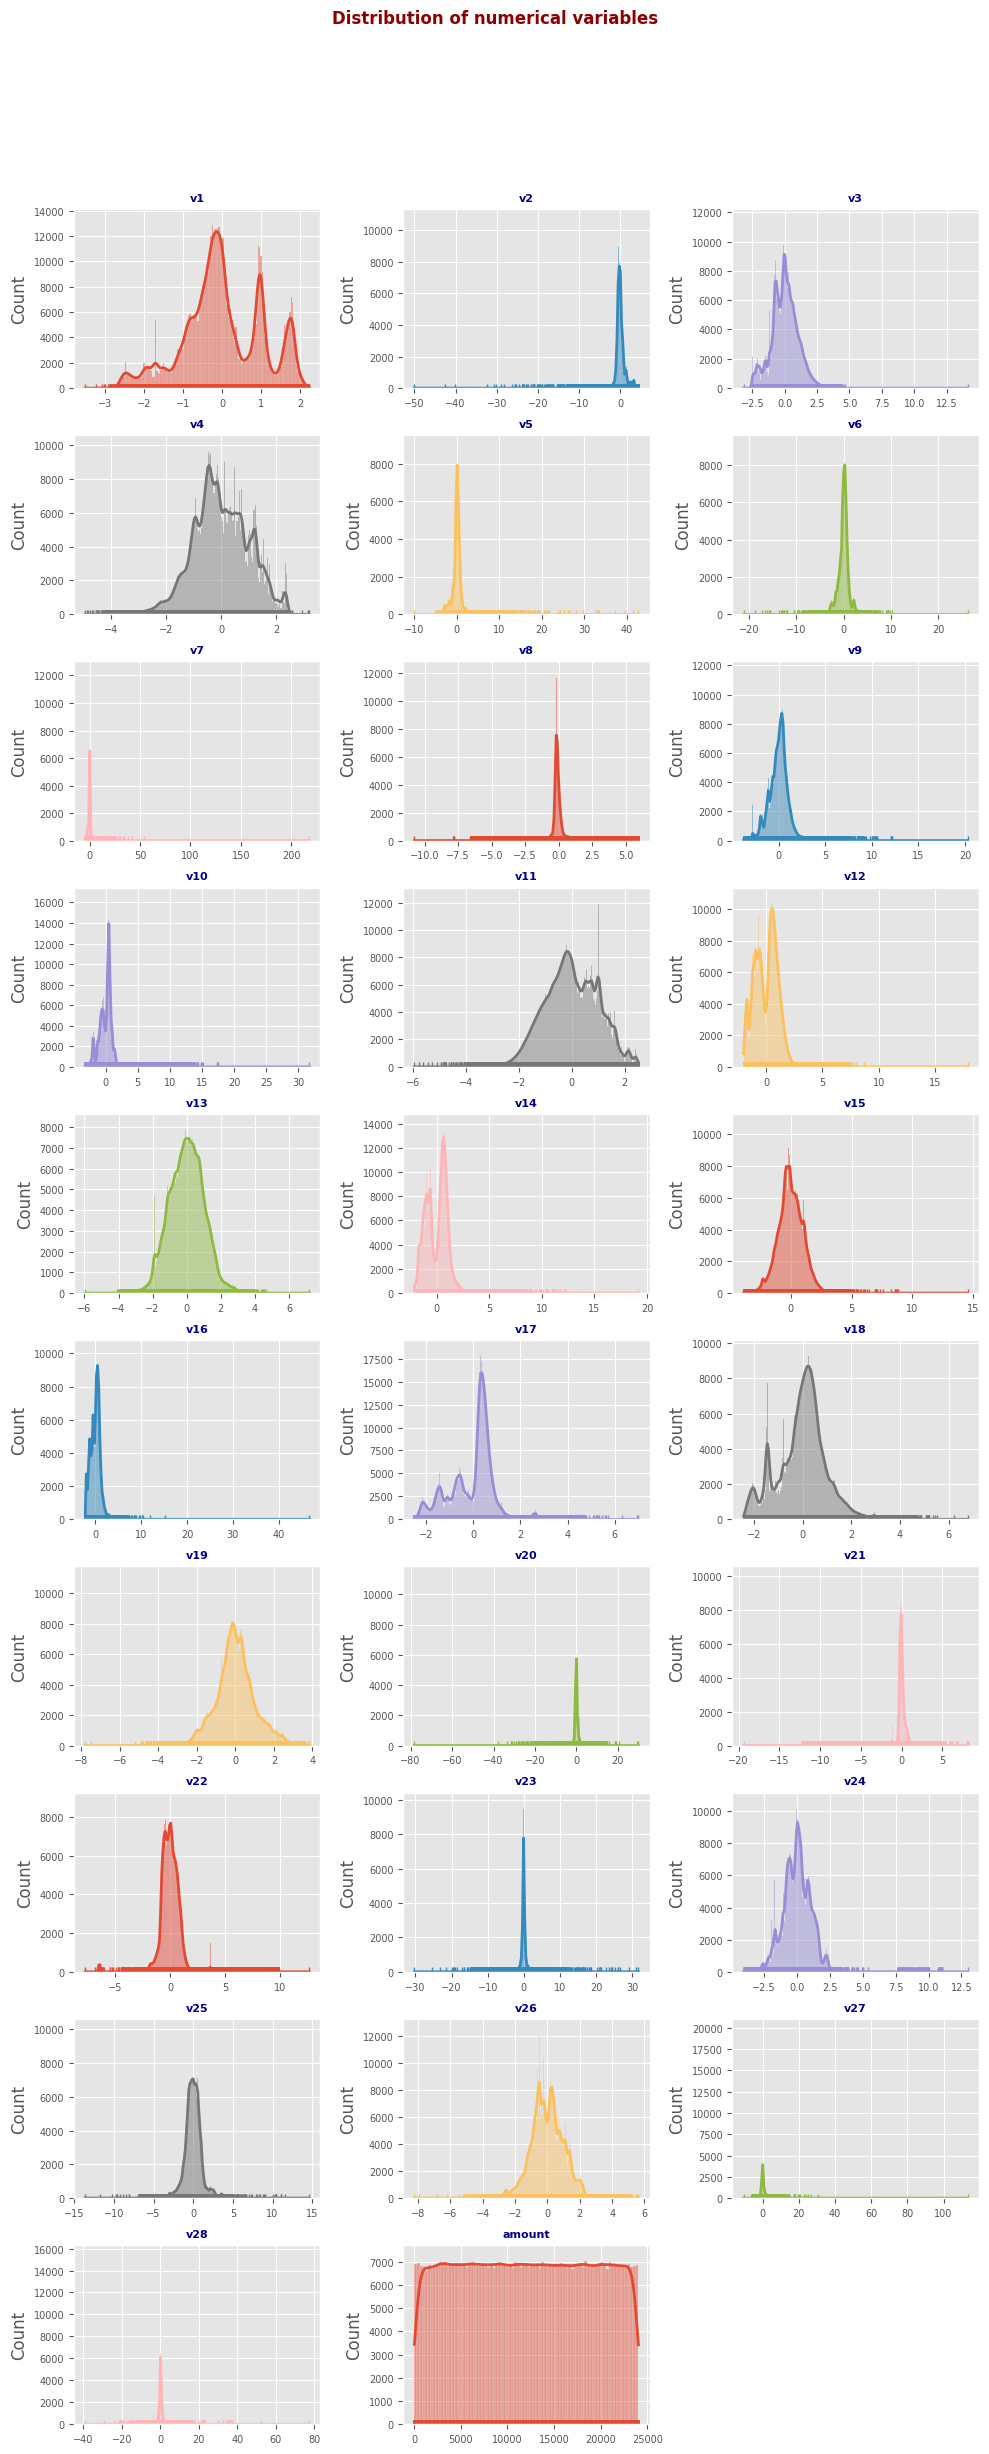

In [16]:
# plot distributions
dist_plots(df=data, cols_to_plot=cols_to_plot)


In [17]:
# skewness and kurtosis
# https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm
for col in cols_to_plot:
    print(f"{col}:")
    print(f"Skewness = {data[col].skew()}")
    print(f"Kurtosis = {data[col].kurt()}")
    print("=="*20)


v1:
Skewness = -0.08341717301015879
Kurtosis = -0.19551088568279074
v2:
Skewness = -1.397951923713946
Kurtosis = 54.50647846202814
v3:
Skewness = 0.014622213363246254
Kurtosis = 0.28868614603280385
v4:
Skewness = -0.04416892714770696
Kurtosis = -0.10335451793576445
v5:
Skewness = 1.5064136757634041
Kurtosis = 47.09935165702095
v6:
Skewness = -0.2016110101307477
Kurtosis = 4.4905101732511685
v7:
Skewness = 19.026866097533325
Kurtosis = 4017.608217329162
v8:
Skewness = 0.2999722258586845
Kurtosis = 18.939201932362025
v9:
Skewness = 0.17105746155506976
Kurtosis = 3.6393235693250436
v10:
Skewness = 0.7404135529207346
Kurtosis = 13.164784821929029
v11:
Skewness = -0.02089056131978458
Kurtosis = -0.3749301739295974
v12:
Skewness = 0.06675895200237957
Kurtosis = -0.21380828444874433
v13:
Skewness = 0.014906385371884177
Kurtosis = -0.007776940607126193
v14:
Skewness = 0.2078348004501865
Kurtosis = 0.8994629656844437
v15:
Skewness = 0.0112329832827567
Kurtosis = 0.40217237781525084
v16:
Skewnes

### What did we learn from looking at the skewness and Kurtosis??

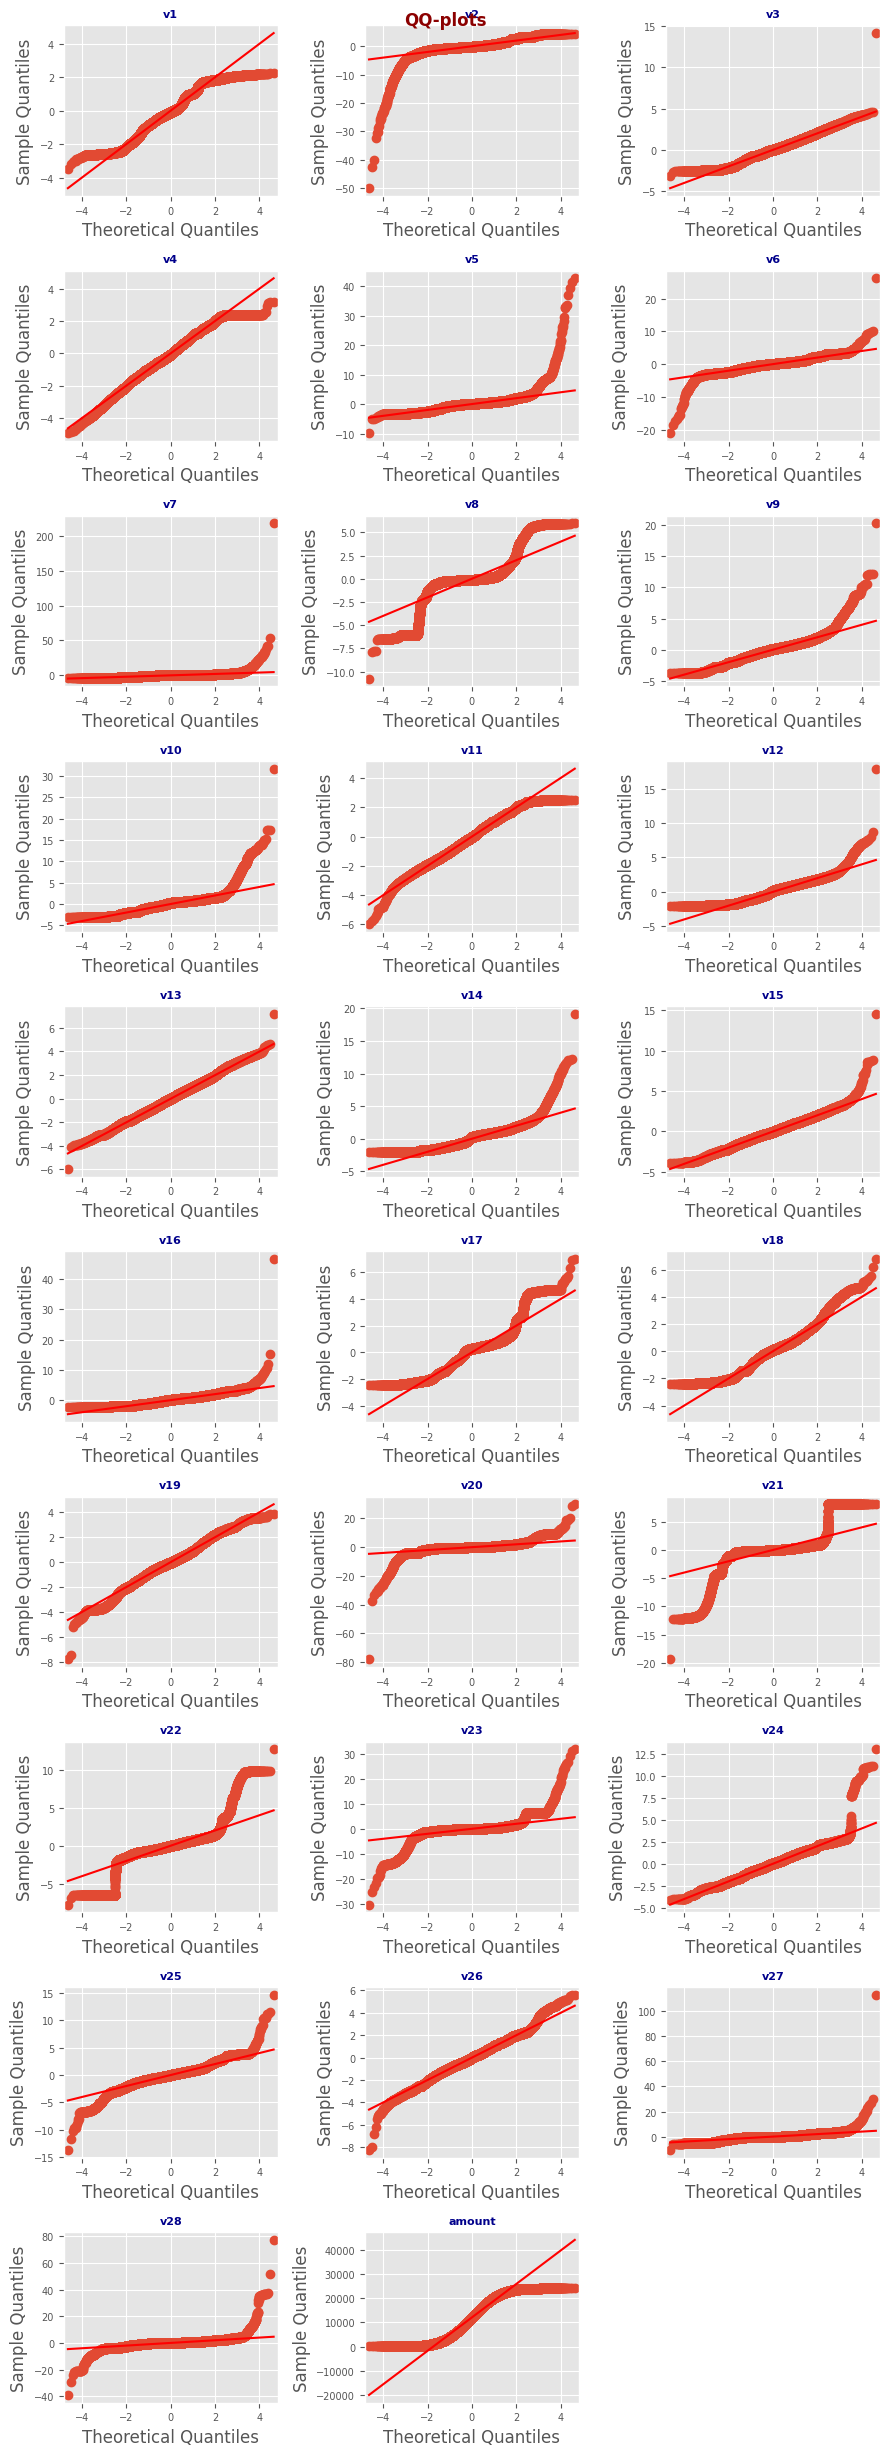

In [18]:
# Q-Q plots
# https://www.itl.nist.gov/div898/handbook/eda/section3/qqplot.htm
qq_plot(df=data, cols_to_plot=cols_to_plot)


### What do we learn from this Q-Q plot?

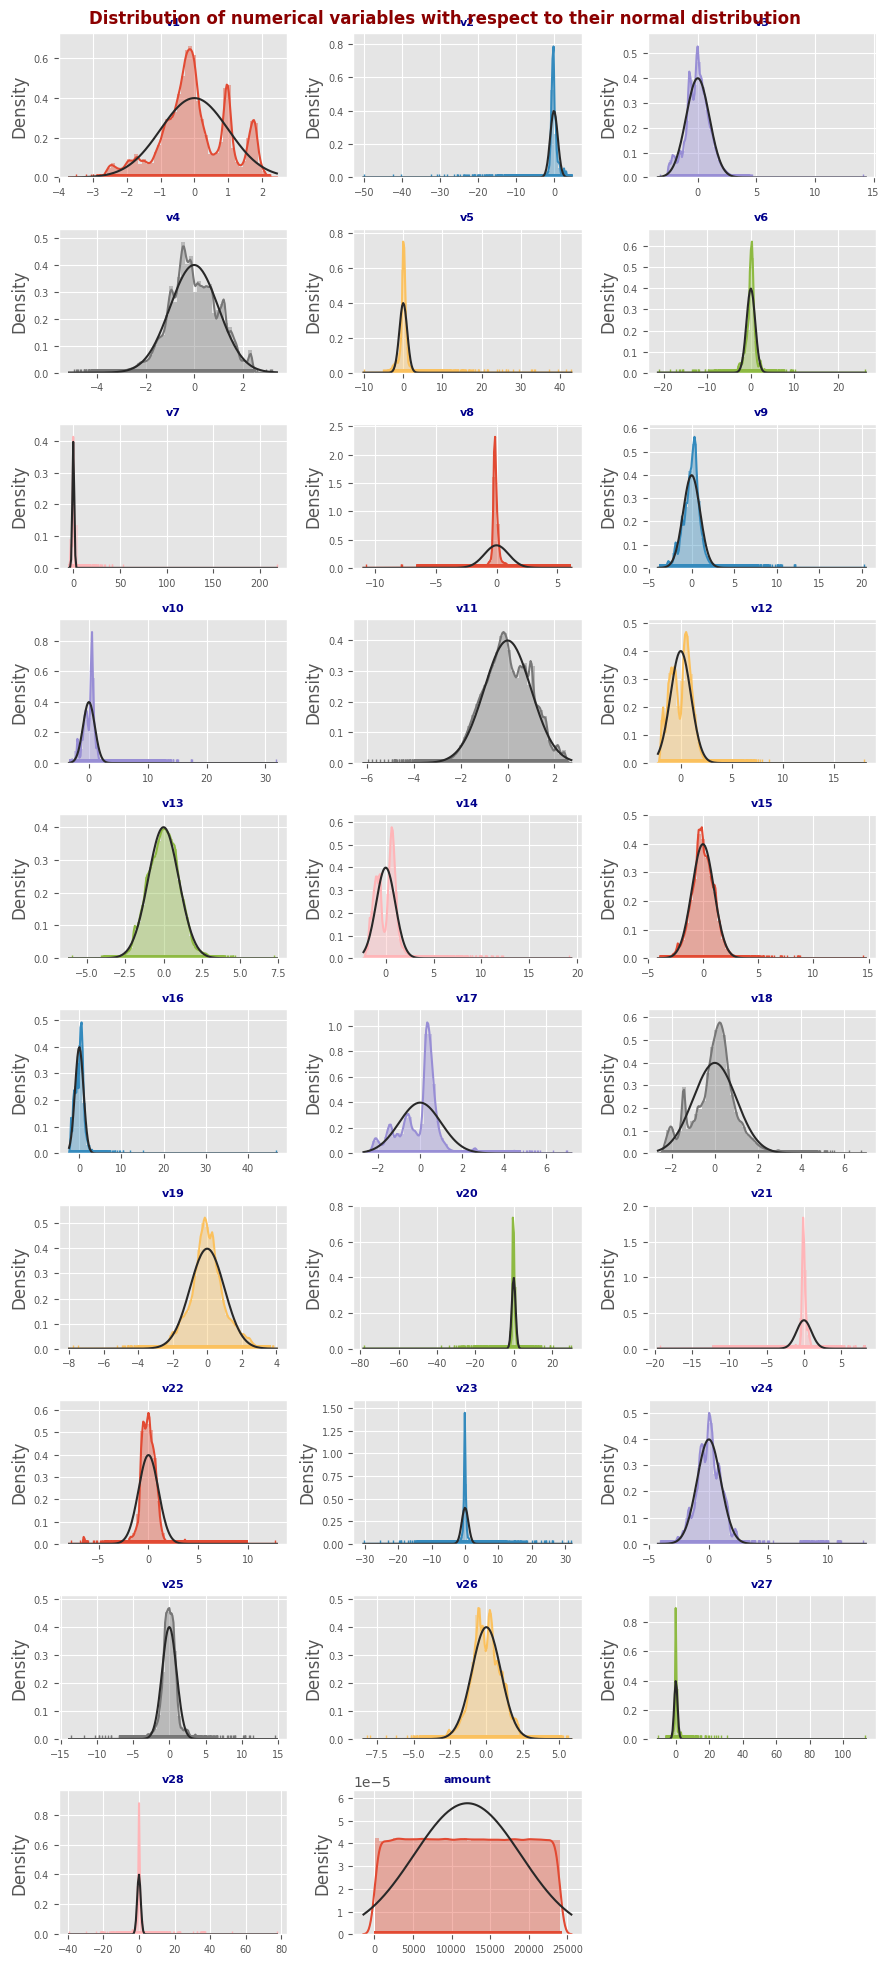

In [19]:
# looking at each variable with respect to its normal distribuition
normal_dist_plot(df=data, cols_to_plot=cols_to_plot)

### What did we learn from looking at feature compared to their normal dist?

In [20]:
# Checking if the variables come from a normal distribution
for col in cols_to_plot:
  p_value = shapiro(data[col])[1]
  result = 'No Normal Distribution' if p_value < 0.05 else 'Normal Distribution'
  print(f'* {col}: p-value = {p_value} => {result}')

* v1: p-value = 0.0 => No Normal Distribution
* v2: p-value = 0.0 => No Normal Distribution
* v3: p-value = 0.0 => No Normal Distribution
* v4: p-value = 0.0 => No Normal Distribution
* v5: p-value = 0.0 => No Normal Distribution
* v6: p-value = 0.0 => No Normal Distribution
* v7: p-value = 0.0 => No Normal Distribution
* v8: p-value = 0.0 => No Normal Distribution
* v9: p-value = 0.0 => No Normal Distribution
* v10: p-value = 0.0 => No Normal Distribution
* v11: p-value = 0.0 => No Normal Distribution
* v12: p-value = 0.0 => No Normal Distribution
* v13: p-value = 1.9442496307594903e-28 => No Normal Distribution
* v14: p-value = 0.0 => No Normal Distribution
* v15: p-value = 0.0 => No Normal Distribution
* v16: p-value = 0.0 => No Normal Distribution
* v17: p-value = 0.0 => No Normal Distribution
* v18: p-value = 0.0 => No Normal Distribution
* v19: p-value = 0.0 => No Normal Distribution
* v20: p-value = 0.0 => No Normal Distribution
* v21: p-value = 0.0 => No Normal Distribution
* v

### What did we learn from checking for normality?

- most of the features are not normal.
- This changes what method of correlation use. 

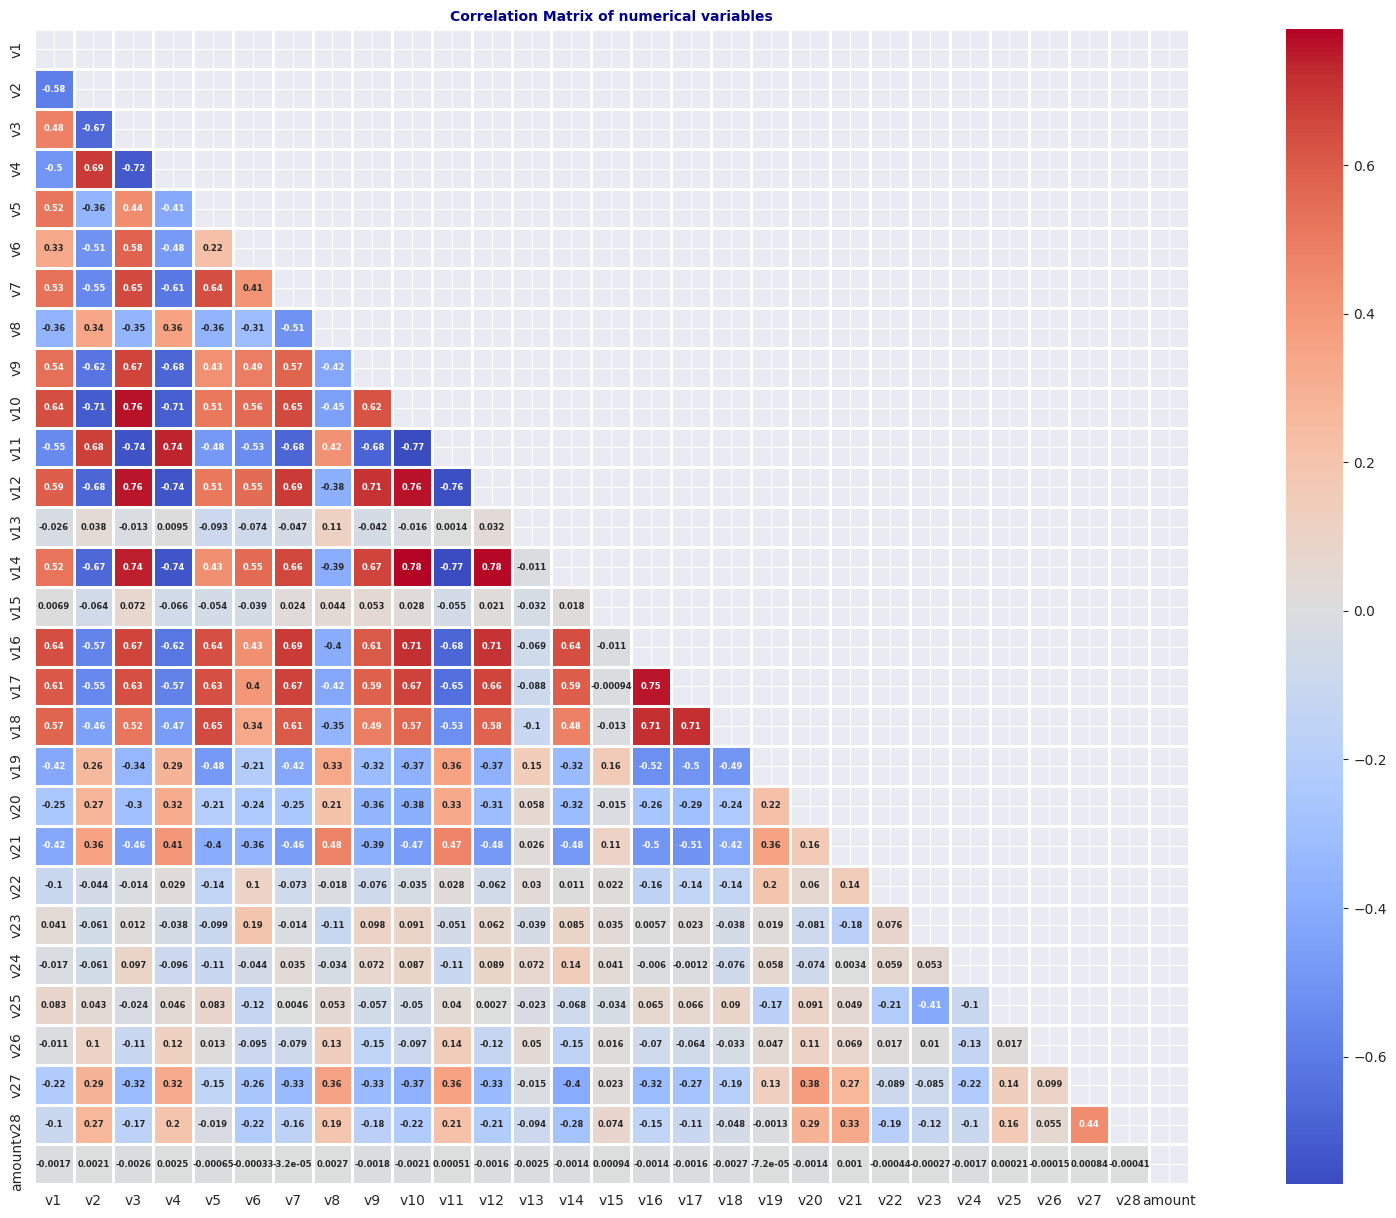

In [21]:
# We generate a correlation matrix between each pair of variables, use the Spearman correlation since the variables do not come from a normal distribution.
cor_plot(df=data, cols_to_plot=cols_to_plot, method='spearman')

### What did we learn from the correlation check?

- There are some relatively highly correlated 
- v16, v17, v18 seem somewhat collinear
- same for v10, v12, v14

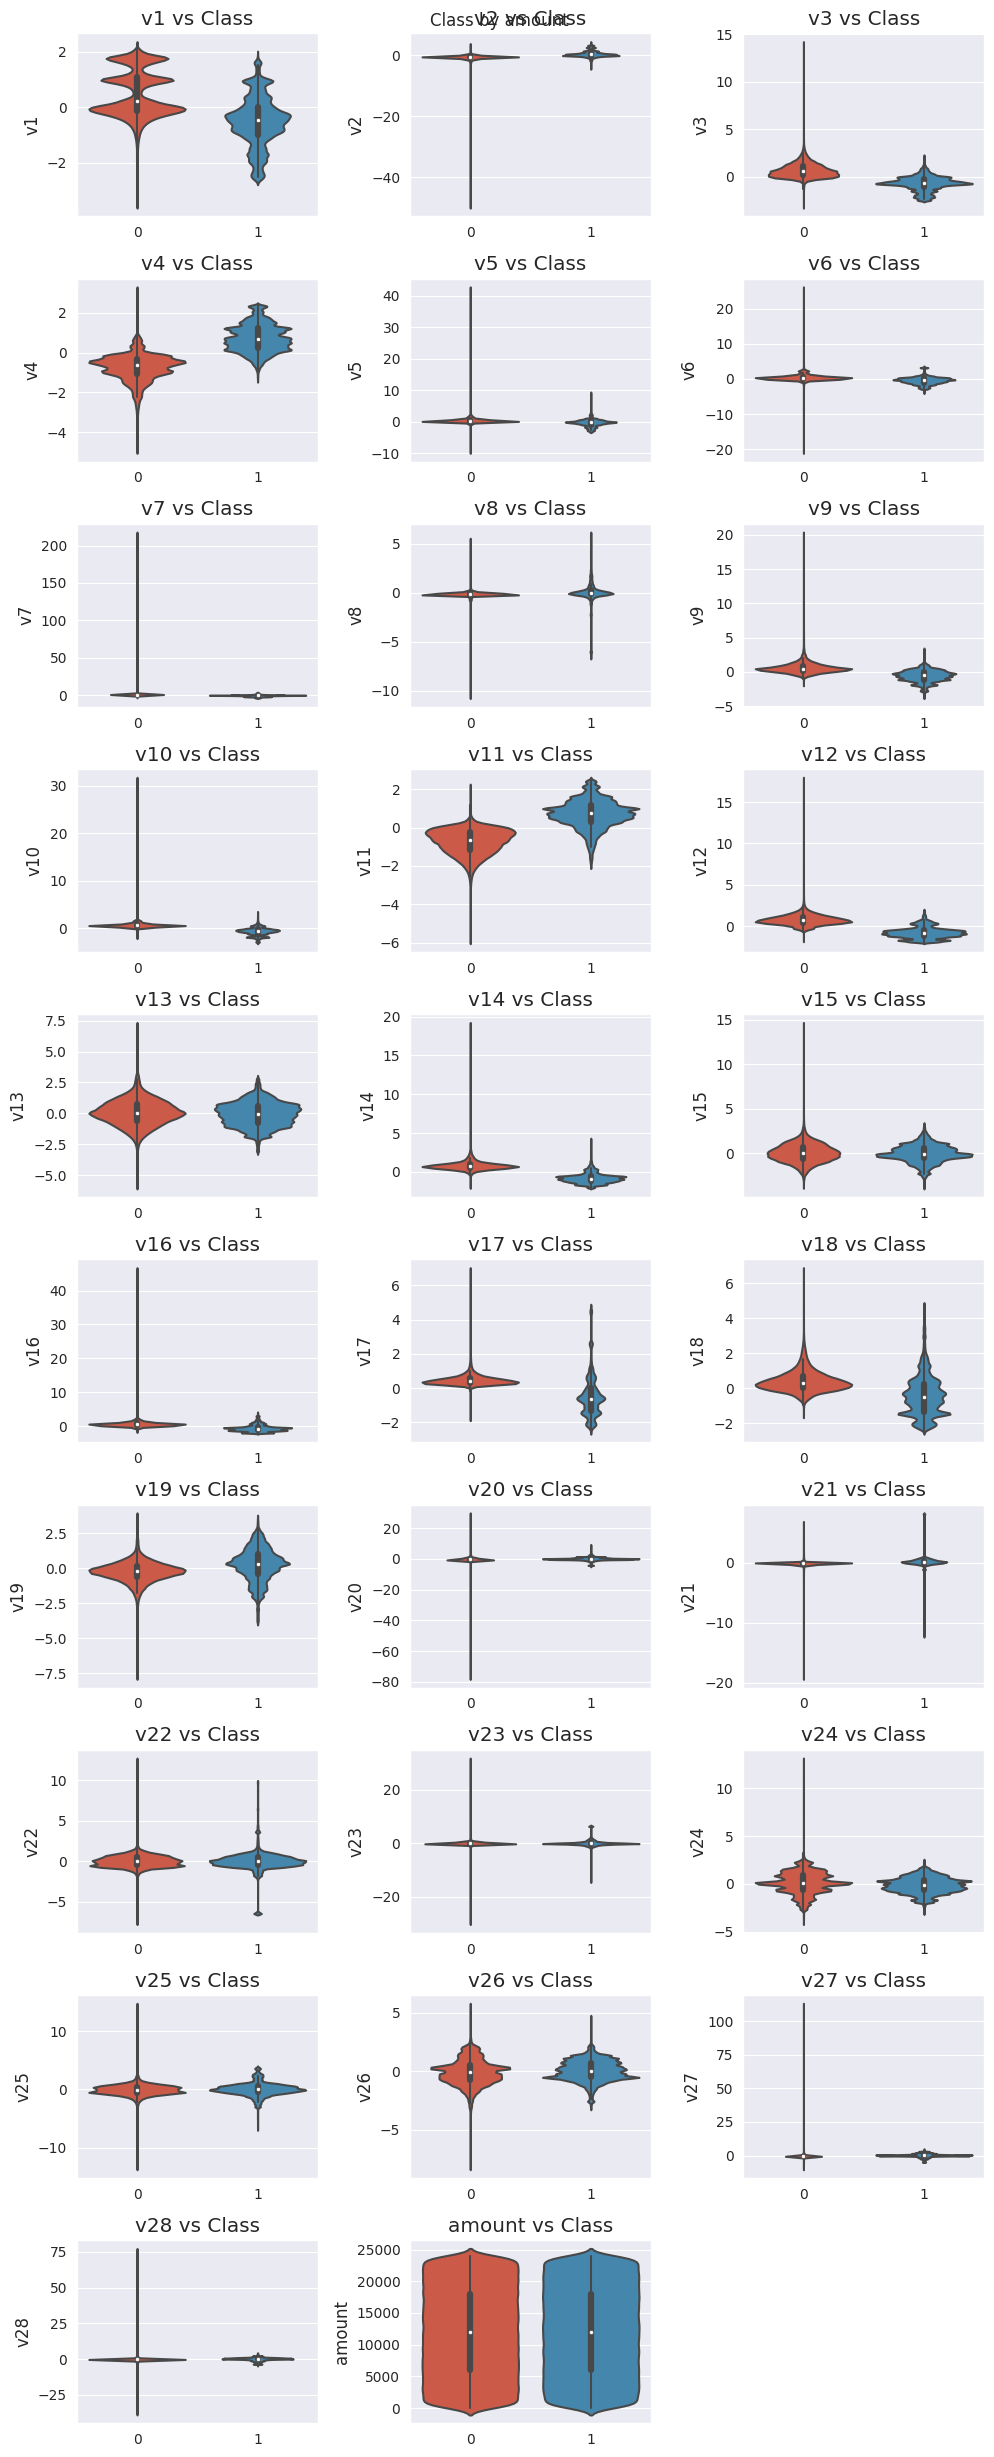

In [22]:
### compare feature distribution by prediction class
sns.set_style("darkgrid")
fig,axes = plt.subplots(nrows = 10, ncols = 3, figsize = (10, 25))
axes = axes.flat

for i,col in enumerate(cols_to_plot):
    sns.violinplot(data, 
                  x = "class", 
                  y = col, 
                  ax = axes[i])
    axes[i].set_xlabel("")
    axes[i].set_title(f"{col} vs Class")
    
fig.delaxes(axes[29])
fig.suptitle(f"Class by {col}")
fig.tight_layout()
fig.show()

### What did we learn from comparing feature distribution by class?

# EDA summary

Most of the EDA in this notebook is interesting but has zero barring on modeling decisions made below. There isn't much use in most of it since the prefered modeling methods are all some varriant of Decision trees. With the exception of the logistic regression there isn't even a need to process the data beyond train/test split. 

I think checking distribution and correlation is useful but Q-Q plots don't seem to add anything. Skewness and Kurtosis also don't seem to add anything. Visually comparing the feature distribution by outcome class is interesting but what does eyeballing the data in this manner do for us?

# Processing

#### Min-Max Scaling vs Standard Scaling

Standard scaling assumes a well-behaved mean/SD: amount is very close to centered and has a lower value for Kurtosis
- This is only needed since we are trying a logistic regression. With a classification problem of this nature I would not even bother checking linear models and stick models that are known to be better at classification. 

In [23]:
# centering and scaling amount
data.amount.skew(), data.amount.kurt()

(0.0016555849611610634, -1.1988636972765643)

In [24]:
scaler = StandardScaler()
data['amount'] = scaler.fit_transform(data[['amount']])[:,0]

#### Train, test, X, y split

In [25]:
# We divide into independent and dependent variables (target).
X = data.drop("class", axis = 1)
y = data["class"]

In [26]:
# train test split
X_train, X_test, y_train, y_test = tts(X,y, 
                                       test_size = 0.3, 
                                       random_state = seed, 
                                       shuffle = True, 
                                       stratify = y)

print(f"X train: {X_train.shape}")
print(f"X test: {X_test.shape}")

X train: (398041, 29)
X test: (170589, 29)


# Modeling

In [27]:
# We define our candidate models.
lr = LogisticRegression(random_state = seed)
cart = tree.DecisionTreeClassifier(random_state=seed)
xgb = XGBClassifier(objective = "binary:logistic", random_state = seed)
lgbm = LGBMClassifier(random_state = seed, verbose = -1)
cb = CatBoostClassifier(random_state = seed,verbose = 0 ) 


models = {'Logistic_Regression':lr, 
         'Cart':cart, 
         'XGB':xgb, 
         'LGBM':lgbm, 
         'CatBoost':cb}

In [28]:
# store AUC
auc_train = {}
auc_test = {}

# store the recall metric
recall_train = {}
recall_test = {}

# store the f2 metric
f2_train = {}
f2_test = {}

# store the confusion matrix
cf_matrix_train = {}
cf_matrix_test = {}

# store the accuracy metric
accuracy_train = {}
accuracy_test = {}

# We store the classification report
clf_report_train = {}
clf_report_test = {}

In [29]:
for model_name, model in models.items():
    start = time.time()
    # Fit model
    model.fit(X_train, y_train)
    end = time.time()
    print(f"* {model_name} training time = {round(end-start, 1)}")
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # AUC score
    auc_train[model_name] = roc_auc_score(y_train, y_pred_train)
    auc_test[model_name]  = roc_auc_score(y_test, y_pred_test)
    print(f" - {model_name} AUC: ", round(auc_test[model_name], 4))
    
    # Accuracy score
    accuracy_train[model_name] = accuracy_score(np.array(y_train), y_pred_train)
    accuracy_test[model_name] = accuracy_score(np.array(y_test), y_pred_test)
    
    # Recall score
    recall_train[model_name] = recall_score(np.array(y_train), y_pred_train)
    recall_test[model_name] = recall_score(np.array(y_test), y_pred_test)
    
    # F2 score
    f2_train[model_name] = fbeta_score(np.array(y_train), y_pred_train, beta = 2)
    f2_test[model_name] = fbeta_score(np.array(y_test), y_pred_test, beta = 2)
    
    # Confusion Matrix
    cf_matrix_train[model_name] = confusion_matrix(np.array(y_train), y_pred_train)
    cf_matrix_test[model_name] = confusion_matrix(np.array(y_test), y_pred_test)
    
    # Classification Report
    # clf_report_train[model_name] = classification_report(np.array(y_train), y_pred_train)
    # clf_report_test[model_name] = classification_report(np.array(y_test), y_pred_test)

* Logistic_Regression training time = 1.5
 - Logistic_Regression AUC:  0.965
* Cart training time = 32.2
 - Cart AUC:  0.9974
* XGB training time = 21.9
 - XGB AUC:  0.9997
* LGBM training time = 2.1
 - LGBM AUC:  0.9991
* CatBoost training time = 26.4
 - CatBoost AUC:  0.9995


# Evaluation

- why use Accuaracy vs AUC?

In [30]:
auc_test

{'Logistic_Regression': 0.9650095455809826,
 'Cart': 0.9974324193235761,
 'XGB': 0.9997362065326987,
 'LGBM': 0.9991148277398194,
 'CatBoost': 0.999542757990011}

In [31]:
# f2 
f2_test

{'Logistic_Regression': 0.9567556353932398,
 'Cart': 0.9980452315603691,
 'XGB': 0.9998944949826505,
 'LGBM': 0.9995053752350055,
 'CatBoost': 0.9998171387846293}

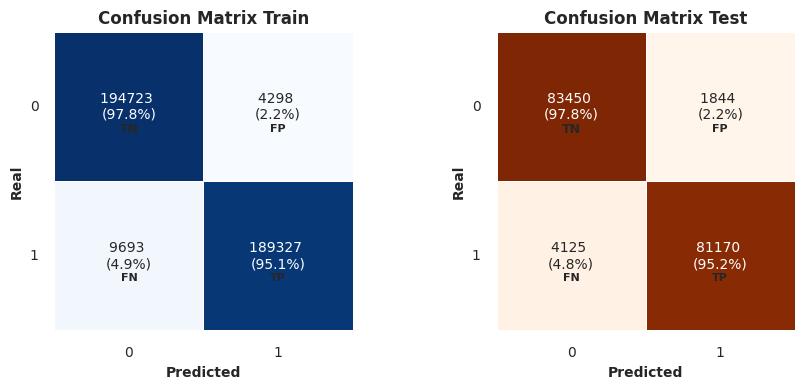

In [32]:
#================================= Logistic Regression =========================
confusion_matrix_plot(cf_matrix_train['Logistic_Regression'],
                      cf_matrix_test['Logistic_Regression'],
                      ["0","1"])



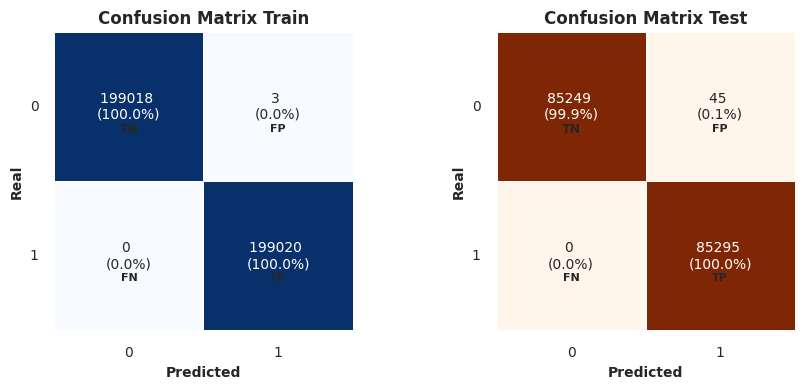

In [33]:

#================================= XGBoost =====================================
confusion_matrix_plot(cf_matrix_train['XGB'],
                      cf_matrix_test['XGB'],
                      ["0","1"])



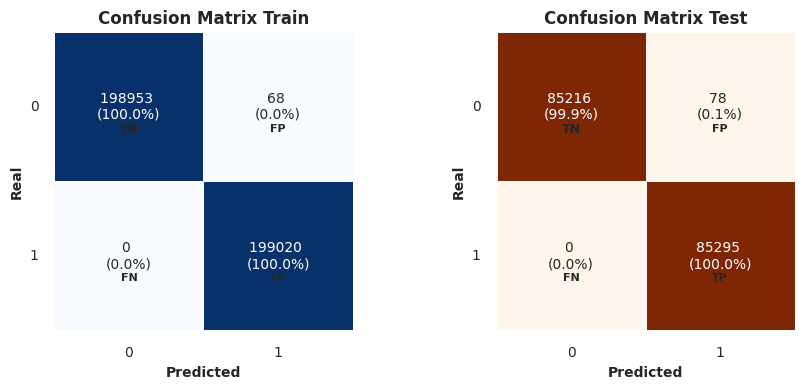

In [34]:
#================================= CatBoost =====================================
confusion_matrix_plot(cf_matrix_train['CatBoost'],
                      cf_matrix_test['CatBoost'],
                      ["0","1"])